In [3]:
using Revise

In [53]:
using RegNeuralODE, Plots, OrdinaryDiffEq, Flux
using Plots.PlotMeasures

In [27]:
# TODO: This is a model from the DiffEqFlux Tutorial. We need to use GPU (TrackerAdjoint)
#       if we want to train the models from the easy-neural-ode paper
vanilla_node = ClassifierNODE(
    Chain(flatten, Dense(784, 20, tanh)),
    NFECounterNeuralODE(Chain(Dense(20, 10, tanh),
                              Dense(10, 10, tanh),
                              Dense(10, 20, tanh)),
                        [0.f0, 1.f0], Tsit5(),
                        save_everystep = false,
                        reltol = 6f-5, abstol = 6f-5,
                        save_start = false),
    Chain(RegNeuralODE.diffeqsol_to_array, Dense(20, 10))
)
opt_vanilla_node = ADAM(0.01)

reg_node = ClassifierNODE(
    Chain(flatten, Dense(784, 20, tanh)),
    NFECounterCallbackNeuralODE(Chain(Dense(20, 10, tanh),
                                      Dense(10, 10, tanh),
                                      Dense(10, 20, tanh)),
                                [0.f0, 1.f0], Tsit5(),
                                save_everystep = false,
                                reltol = 6f-5, abstol = 6f-5,
                                save_start = false),
    Chain(RegNeuralODE.diffeqsol_to_array, Dense(20, 10))
)
opt_reg_node = ADAM(0.01)

ADAM(0.01, (0.9, 0.999), IdDict{Any,Any}())

In [9]:
train_dataloader, test_dataloader = load_mnist(4096);

In [28]:
vanilla_node, vanilla_node_nfe_count, vanilla_node_train_accuracy, vanilla_node_test_accuracy =
    RegNeuralODE.train!(vanilla_node, opt_vanilla_node, 50,
                        train_dataloader, test_dataloader,
                        RegNeuralODE.get_loss_function(vanilla_node))

Before Training || Train Accuracy: 0.133 || Test Accuracy: 0.130
Iterations Completed: [ 10 /  15]
Epoch:   1 || Train Accuracy: 0.827 || Test Accuracy: 0.820 || NFE: 33.000
Iterations Completed: [ 10 /  15]
Epoch:   2 || Train Accuracy: 0.883 || Test Accuracy: 0.876 || NFE: 33.000
Iterations Completed: [ 10 /  15]
Epoch:   3 || Train Accuracy: 0.907 || Test Accuracy: 0.904 || NFE: 33.000
Iterations Completed: [ 10 /  15]
Epoch:   4 || Train Accuracy: 0.924 || Test Accuracy: 0.915 || NFE: 33.000
Iterations Completed: [ 10 /  15]
Epoch:   5 || Train Accuracy: 0.934 || Test Accuracy: 0.925 || NFE: 33.000
Iterations Completed: [ 10 /  15]
Epoch:   6 || Train Accuracy: 0.940 || Test Accuracy: 0.931 || NFE: 35.000
Iterations Completed: [ 10 /  15]
Epoch:   7 || Train Accuracy: 0.945 || Test Accuracy: 0.935 || NFE: 39.000
Iterations Completed: [ 10 /  15]
Epoch:   8 || Train Accuracy: 0.950 || Test Accuracy: 0.940 || NFE: 39.000
Iterations Completed: [ 10 /  15]
Epoch:   9 || Train Accuracy:

(ClassifierNODE{NFECounterNeuralODE{Chain{Tuple{Dense{typeof(tanh),Array{Float32,2},Array{Float32,1}},Dense{typeof(tanh),Array{Float32,2},Array{Float32,1}},Dense{typeof(tanh),Array{Float32,2},Array{Float32,1}}}},Array{Float32,1},Flux.var"#34#36"{Chain{Tuple{Dense{typeof(tanh),Array{Float32,2},Array{Float32,1}},Dense{typeof(tanh),Array{Float32,2},Array{Float32,1}},Dense{typeof(tanh),Array{Float32,2},Array{Float32,1}}}}},Array{Float32,1},Tuple{Tsit5},Base.Iterators.Pairs{Symbol,Real,NTuple{4,Symbol},NamedTuple{(:save_everystep, :reltol, :abstol, :save_start),Tuple{Bool,Float32,Float32,Bool}}}},Flux.var"#34#36"{Chain{Tuple{typeof(flatten),Dense{typeof(tanh),Array{Float32,2},Array{Float32,1}}}}},Flux.var"#34#36"{Chain{Tuple{typeof(RegNeuralODE.diffeqsol_to_array),Dense{typeof(identity),Array{Float32,2},Array{Float32,1}}}}},Array{Float32,1}}(Flux.var"#34#36"{Chain{Tuple{typeof(flatten),Dense{typeof(tanh),Array{Float32,2},Array{Float32,1}}}}}(Chain(flatten, Dense(784, 20, tanh))), NFECounter

In [29]:
reg_node, reg_node_nfe_count, reg_node_train_accuracy, reg_node_test_accuracy =
    RegNeuralODE.train!(reg_node, opt_reg_node, 50,
                        train_dataloader, test_dataloader,
                        RegNeuralODE.get_loss_function(reg_node))

Before Training || Train Accuracy: 0.104 || Test Accuracy: 0.105
Iterations Completed: [ 10 /  15]
Epoch:   1 || Train Accuracy: 0.843 || Test Accuracy: 0.843 || NFE: 33.000
Iterations Completed: [ 10 /  15]
Epoch:   2 || Train Accuracy: 0.891 || Test Accuracy: 0.885 || NFE: 33.000
Iterations Completed: [ 10 /  15]
Epoch:   3 || Train Accuracy: 0.915 || Test Accuracy: 0.908 || NFE: 33.000
Iterations Completed: [ 10 /  15]
Epoch:   4 || Train Accuracy: 0.929 || Test Accuracy: 0.922 || NFE: 33.000
Iterations Completed: [ 10 /  15]
Epoch:   5 || Train Accuracy: 0.939 || Test Accuracy: 0.928 || NFE: 33.000
Iterations Completed: [ 10 /  15]
Epoch:   6 || Train Accuracy: 0.944 || Test Accuracy: 0.930 || NFE: 33.000
Iterations Completed: [ 10 /  15]
Epoch:   7 || Train Accuracy: 0.949 || Test Accuracy: 0.937 || NFE: 33.000
Iterations Completed: [ 10 /  15]
Epoch:   8 || Train Accuracy: 0.953 || Test Accuracy: 0.939 || NFE: 33.000
Iterations Completed: [ 10 /  15]
Epoch:   9 || Train Accuracy:

(ClassifierNODE{NFECounterCallbackNeuralODE{Chain{Tuple{Dense{typeof(tanh),Array{Float32,2},Array{Float32,1}},Dense{typeof(tanh),Array{Float32,2},Array{Float32,1}},Dense{typeof(tanh),Array{Float32,2},Array{Float32,1}}}},Array{Float32,1},Flux.var"#34#36"{Chain{Tuple{Dense{typeof(tanh),Array{Float32,2},Array{Float32,1}},Dense{typeof(tanh),Array{Float32,2},Array{Float32,1}},Dense{typeof(tanh),Array{Float32,2},Array{Float32,1}}}}},Array{Float32,1},Tuple{Tsit5},Base.Iterators.Pairs{Symbol,Real,NTuple{4,Symbol},NamedTuple{(:save_everystep, :reltol, :abstol, :save_start),Tuple{Bool,Float32,Float32,Bool}}}},Flux.var"#34#36"{Chain{Tuple{typeof(flatten),Dense{typeof(tanh),Array{Float32,2},Array{Float32,1}}}}},Flux.var"#34#36"{Chain{Tuple{typeof(RegNeuralODE.diffeqsol_to_array),Dense{typeof(identity),Array{Float32,2},Array{Float32,1}}}}},Array{Float32,1}}(Flux.var"#34#36"{Chain{Tuple{typeof(flatten),Dense{typeof(tanh),Array{Float32,2},Array{Float32,1}}}}}(Chain(flatten, Dense(784, 20, tanh))), NF

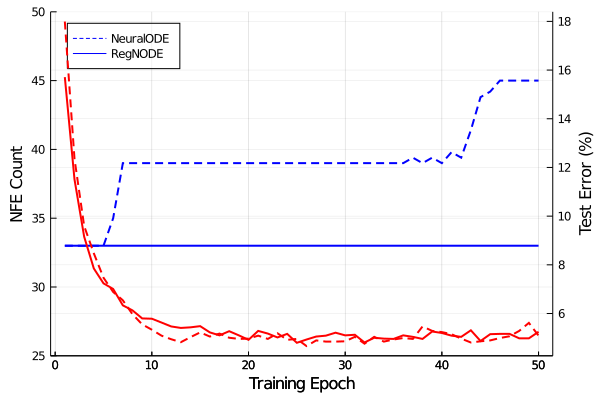

In [64]:
plot(vanilla_node_nfe_count, legend = :topleft, lw = 2,
     label = "NeuralODE", color = :blue, linestyle = :dash,
     right_margin = 10mm)
plot!(reg_node_nfe_count, legend = :topleft, lw = 2,
      label = "RegNODE", color = :blue, right_margin = 10mm)
ylims!(25.0, 50.0)
ylabel!("NFE Count")
plt = twinx()
plot!(plt, (1 .- vanilla_node_test_accuracy[2:end]) * 100, color=:red,
      legend=false, lw = 2, linestyle = :dash, right_margin = 10mm)
plot!(plt, (1 .- reg_node_test_accuracy[2:end]) * 100, color=:red,
      legend=false, lw = 2, right_margin = 10mm)
ylabel!(plt, "Test Error (%)")
xlabel!("Training Epoch")
# savefig("mnist_classification.png")